# Consistency diffusion network

Frame number of video is denoted as 

$$f=1, f=2, f=3, \cdots, f = F$$

Time step of diffusion process is denoted as 

$$t=T, t=T-1, \cdots, t=0$$

**Input:** F frames of hed edge images are denoted as 

$$h_1, h_2, \cdots, h_F$$

The initial ($t=T$) noisy latents for frame $f=f$ are denoted as

$$i_1^T, i_2^T, \cdots, i_F^T$$

The denoising step goes from t to t-1, at time $t=t$ the noisy latents for frame $f=f$ are denoted as

$$i_1^t, i_2^t, \cdots, i_F^t$$

**Output:** The output video frames are denoted as 

$$i_1^0, i_2^0, \cdots, i_F^0$$

**Controlnet:** For a standard inference method, at each time step, we predict next time step as $i_f^{t-1} \sim i_f^t - Controlnet(h_f, i_f^t)$

Starting from noisy latents at time $t =t$, we jointly optimize successive frames $i_f^t,i_{f-1}^t$ to minimize the consistency loss:

$$ \underset{i_f^t,i_{f-1}^t}{argmin}\quad ||[i_f^t - Controlnet(h_{f-1},i_f^t] - [i_{f-1}^{t} - Controlnet(h_{f},i_{f-1}^t]||$$

After we get the consistency for all the frames, we can run the standard inference of controlnet for current frame.


$$i_f^{t-1} \sim i_f^t - Controlnet(h_f, i_f^t)$$


The procedures will be done for all time step $t$ till time step $t=T$ when we have the output video




In [2]:
from base64 import b64encode
import os

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline, UniPCMultistepScheduler
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import numpy as np
import torchvision.transforms.functional as F

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load images

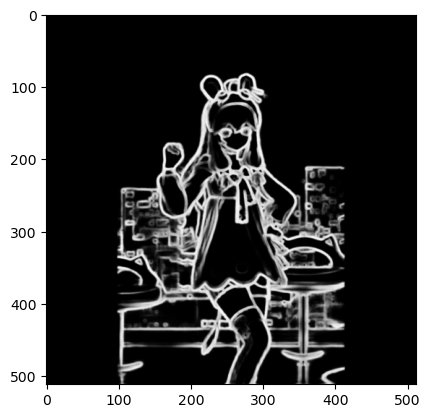

In [4]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, 0, 'constant')
        
root_path = "/home/ubuntu/AI二次元/0319_jiaran_yao"

# hed图片位置
hed_img_path = os.path.join(root_path, "transfered_images")
file_list = os.listdir(hed_img_path)
img_num = len(file_list)
img_num = 100
hed_img_list = []
for i in range(img_num):
    filename = str(i+1) + ".png"
    file_path = os.path.join(hed_img_path, filename)
    hed_image = Image.open(file_path)
    hed_image = SquarePad()(hed_image)
    hed_image = F.resize(hed_image, size=(512,512))   
    hed_img_list.append(hed_image)
plt.imshow(hed_image)

# Test original pipeline

In [ ]:
# Loading model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "gsdf/Counterfeit-V2.5", controlnet=controlnet, torch_dtype=torch.float16
)
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


pipe = pipe.to("cuda")

## Load hed images and random noise

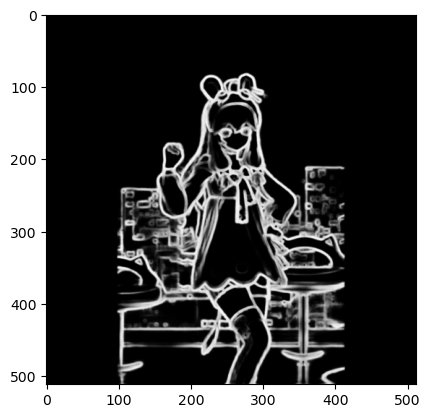

In [32]:
root_path = "/home/ubuntu/AI二次元/0319_jiaran_yao"

# Load images
hed_img_path = os.path.join(root_path, "transfered_images")
file_list = os.listdir(hed_img_path)
img_num = len(file_list)
img_num = 100
hed_img_list = []
for i in range(img_num):
    filename = str(i+1) + ".png"
    file_path = os.path.join(hed_img_path, filename)
    hed_image = Image.open(file_path)
    hed_image = SquarePad()(hed_image)
    hed_image = F.resize(hed_image, size=(512,512))   
    hed_img_list.append(hed_image)
plt.imshow(hed_image)

## Generate random noise

In [6]:
height = 512              
width = 512 
batch_size = 1

noisy_img_list = []

for i in range(img_num):
    # Prep latents
    torch.manual_seed(32)
    latents = torch.randn(
      (batch_size, 4, height // 8, width // 8),
    )
    noisy_img_list.append(latents)
print(torch.allclose(noisy_img_list[0],noisy_img_list[5]))

True


# Run pipeline controlnet as a test

In [ ]:
# Loading model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "gsdf/Counterfeit-V2.5", controlnet=controlnet, torch_dtype=torch.float16
)
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
pipe = pipe.to("cuda")

torch.manual_seed(32)
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output1 = pipe(
    prompt,
    hed_img_list[0],
    negative_prompt=negative_prompt,
    num_inference_steps=20,
)

torch.manual_seed(32)
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output2 = pipe(
    prompt,
    hed_img_list[50],
    negative_prompt=negative_prompt,
    num_inference_steps=20,
)

plt.figure(figsize=(20,20))
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(hed_img_list[0])
axs[0,1].imshow(output1[0][0])
axs[1,0].imshow(hed_img_list[1])
axs[1,1].imshow(output2[0][0])

# 自定义 Controlnet

Controlnet
https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_controlnet.py#L706

Scheduler
https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py#L77


## 公用部分

In [33]:
vae = pipe.vae.to("cuda")
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.to("cuda")
unet = pipe.unet.to("cuda")
scheduler = pipe.scheduler
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16).to("cuda")

# General settings
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
image = hed_img_list[0]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 7.5
controlnet_conditioning_scale = 1.0
# 以下是没啥用的
batch_size = 1
device = pipe._execution_device
do_classifier_free_guidance = guidance_scale > 1.0

num_images_per_prompt = 1
eta = 0.0
generator = None
latents = None
prompt_embeds = None
negative_prompt_embeds = None
output_type = "pil"
return_dict = True
callback = None
callback_steps = 1
cross_attention_kwargs = None
# check inputs
pipe.check_inputs(
            prompt,
            image,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            controlnet_conditioning_scale,
        )

In [42]:
# prompt embedding is the same for all frames
prompt_embeds = pipe._encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
    negative_prompt,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
)
# scheduler is shared for all frames
scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler.timesteps
# extra kwargs
extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
# denoising warm up steps
num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order

In [51]:
# Prepare one frame (initialize noisy latents and hed images)
def prepare_one_frame(hed_image, seed = 32):
  condition_latents = pipe.prepare_image(
      image=hed_image,
      width=width,
      height=height,
      batch_size=batch_size * num_images_per_prompt,
      num_images_per_prompt=num_images_per_prompt,
      device=device,
      dtype=controlnet.dtype,
      do_classifier_free_guidance=do_classifier_free_guidance,
  )  

  torch.manual_seed(seed)
  num_channels_latents = unet.in_channels
  noisy_latents = pipe.prepare_latents(
      batch_size * num_images_per_prompt,
      num_channels_latents,
      height,
      width,
      prompt_embeds.dtype,
      device,
      generator,
      latents = None,
  )

  return condition_latents, noisy_latents

data_list = []
for i in range(len(hed_img_list)):
  condition_latents, noisy_latents = prepare_one_frame(hed_img_list[i], seed = 32)
  data_list.append([condition_latents, noisy_latents])

In [46]:
  image = pipe.prepare_image(
      image=hed_img_list[0],
      width=width,
      height=height,
      batch_size=batch_size * num_images_per_prompt,
      num_images_per_prompt=num_images_per_prompt,
      device=device,
      dtype=controlnet.dtype,
      do_classifier_free_guidance=do_classifier_free_guidance,
  )  
  print(image.shape)

torch.Size([2, 3, 512, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

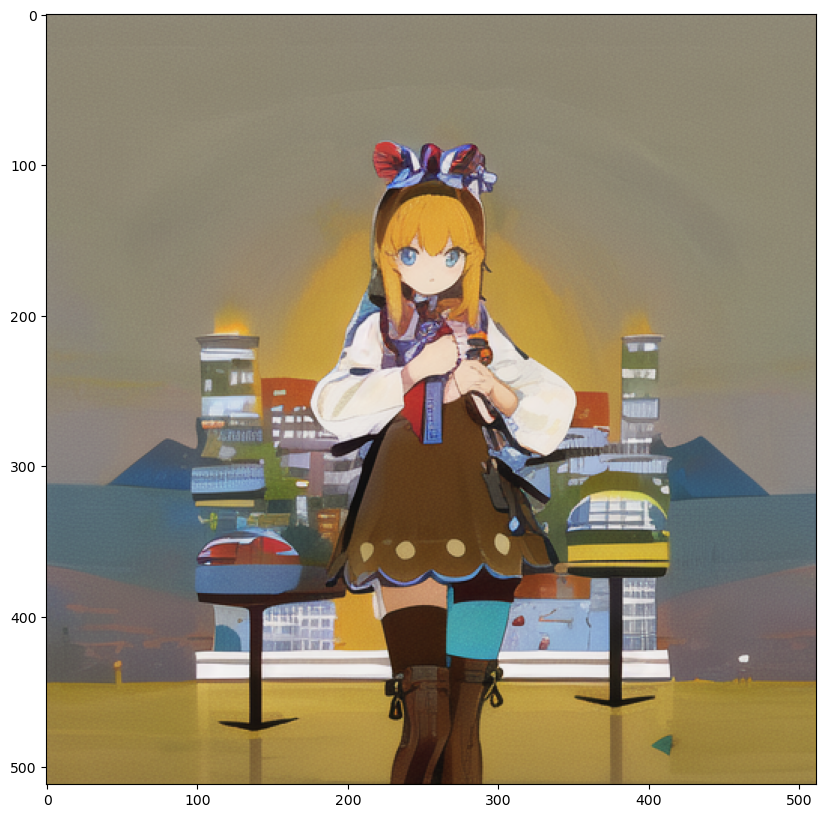

In [ ]:
torch.manual_seed(32)
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output = pipe(
    prompt,
    hed_img_list[0],
    negative_prompt=negative_prompt,
    num_inference_steps=20,
)
output
plt.figure(figsize=(10,10))
plt.imshow(output[0][0])

# 拆分Controlnet

https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/controlnet
https://github.com/huggingface/diffusers/blob/v0.14.0/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_controlnet.py#L574

In [ ]:
# vae = AutoencoderKL.from_pretrained("gsdf/Counterfeit-V2.5", subfolder="vae")
# # tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
# # text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
# text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# # The UNet model for generating the latents.
# unet = UNet2DConditionModel.from_pretrained("gsdf/Counterfeit-V2.5", subfolder="unet")
# scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# # To the GPU we go!
# vae = vae.to(torch_device)
# text_encoder = text_encoder.to(torch_device)
# unet = unet.to(torch_device);
vae = pipe.vae.to("cuda")
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder.to("cuda")
unet = pipe.unet.to("cuda")
scheduler = pipe.scheduler
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16).to("cuda")

In [ ]:
controlnet_conditioning_scale = 1.0

## Encode input prompt

In [ ]:
prompt = "masterpiece, best quality, 1girl, solo"
negative_prompt = "nsfw, lowres, bad anatomy, bad hands, text, error, missing fingers,extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
device = pipe._execution_device
num_images_per_prompt = 1
do_classifier_free_guidance = True
with torch.no_grad():
    prompt_embeds = pipe._encode_prompt(
        prompt,
        device = device,
        num_images_per_prompt = num_images_per_prompt,
        do_classifier_free_guidance = do_classifier_free_guidance,
        negative_prompt = negative_prompt,)
    print(prompt_embeds.shape)

torch.Size([2, 77, 768])


## Prepare condition image

In [ ]:
with torch.no_grad():
    hed_image = pipe.prepare_image(
        hed_img_list[0],
        width,
        height,
        batch_size * num_images_per_prompt,
        num_images_per_prompt,
        device,
        pipe.controlnet.dtype,
        do_classifier_free_guidance = do_classifier_free_guidance,
    )
# plt.imshow(hed_image[0].permute(1,2,0).cpu().detach().numpy().astype(np.uint8)*255)
# hed_image = torch.cat([hed_image] * 2)
# torch.Size([4, 3, 512, 512])

## Prepare timesteps

In [ ]:
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = scheduler.timesteps

## Prepare latent variables

In [ ]:
num_channels_latents = pipe.unet.in_channels
latents = None
with torch.no_grad():
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        None,
        latents,
    )
    latents = latents.type(torch.float16)
print(latents.shape, latents.dtype)

torch.Size([1, 4, 64, 64]) torch.float16


In [ ]:
# print(latents.device, t.device, hed_image.device, prompt_embeds.device)
# print(latents.dtype, t.dtype, hed_image.dtype, prompt_embeds.dtype)

## Prepare extra kwargs

In [ ]:
extra_step_kwargs = pipe.prepare_extra_step_kwargs(None, eta=0.0)

## Denoising loop

In [ ]:
cross_attention_kwargs = None
guidance_scale = 7.5
blue_loss_scale = 200

In [ ]:
target_image = Image.open("/home/ubuntu/AI二次元/0319_jiaran_yao/input_images/1.png")
target_image = SquarePad()(target_image)
target_image = F.resize(target_image, size=(512,512))   
type(target_image)

PIL.Image.Image

In [ ]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device).type(torch.float16)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

In [ ]:
target_latents = pil_to_latent(target_image)

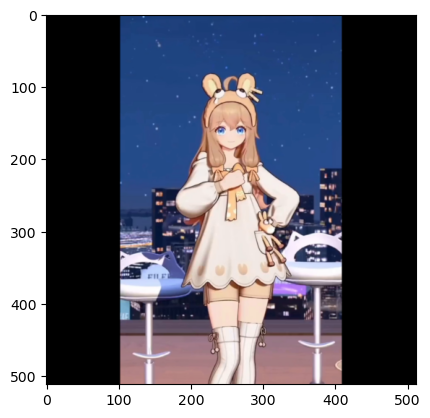

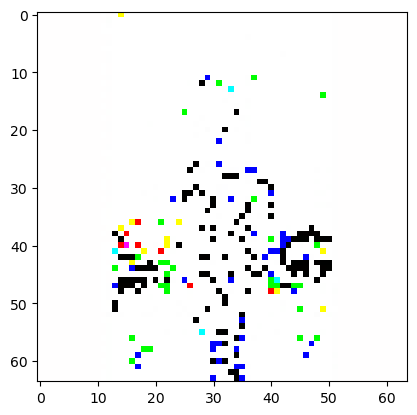

In [ ]:
plt.imshow(target_image)
plt.show()
plt.imshow(target_latents[0].permute(1,2,0).cpu().type(torch.uint8))

In [ ]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error
def rec_loss(target_im, object_im):
    # How far are the blue channel values to 0.9:
    # 想要让 object_im 去学习 target_im
    error = torch.abs(target_im - object_im).mean() # [:,2] -> all images in batch, only the blue channel
    return error

In [ ]:
num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order
for i, t in enumerate(timesteps):
    print(i)
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
        down_block_res_samples, mid_block_res_sample = controlnet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=hed_image,
            return_dict=False,
        )

        down_block_res_samples = [
            down_block_res_sample * controlnet_conditioning_scale
            for down_block_res_sample in down_block_res_samples
        ]
        mid_block_res_sample *= controlnet_conditioning_scale

    # predict the noise residual
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=cross_attention_kwargs,
            down_block_additional_residuals=down_block_res_samples,
            mid_block_additional_residual=mid_block_res_sample,
        ).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
#     if i%5 == 0:
#         # Requires grad on the latents
#         latents = latents.detach().requires_grad_()

#         # Get the predicted x0:
#         # latents_x0 = latents - sigma * noise_pred
#         latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

#         # Decode to image space
#         denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

#         # Calculate loss
#         loss = blue_loss(denoised_images) * blue_loss_scale
        
#         # Occasionally print it out
#         if i%10==0:
#             print(i, 'loss:', loss.item())

#         # Get gradient
#         cond_grad = torch.autograd.grad(loss, latents)[0]
        
#         sigma = scheduler.sigmas[i]

#         # Modify the latents based on this gradient
#         latents = latents.detach() - cond_grad * sigma**2   
#     if i%5 == 0:
#         latents = latents.detach().requires_grad_()
#         latent_model_input = torch.cat([latents] * 2)
#         latent_model_input = scheduler.scale_model_input(latent_model_input, t)
#         down_block_res_samples, mid_block_res_sample = controlnet(
#             latent_model_input,
#             t,
#             encoder_hidden_states=prompt_embeds,
#             controlnet_cond=hed_image,
#             return_dict=False,
#         )

#         down_block_res_samples = [
#             down_block_res_sample * controlnet_conditioning_scale
#             for down_block_res_sample in down_block_res_samples
#         ]
#         mid_block_res_sample *= controlnet_conditioning_scale
        
#         noise_pred_temp = pipe.unet(
#             latent_model_input,
#             t,
#             encoder_hidden_states=prompt_embeds,
#             cross_attention_kwargs=cross_attention_kwargs,
#             down_block_additional_residuals=down_block_res_samples,
#             mid_block_additional_residual=mid_block_res_sample,
#         ).sample
        
#         noise_pred_uncond, noise_pred_text = noise_pred_temp.chunk(2)
#         noise_pred_temp = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

#         latents_x0 = scheduler.step(noise_pred_temp, t, latents).prev_sample
#         rec_loss_ = rec_loss(target_latents, latents_x0)
#         cond_grad = torch.autograd.grad(rec_loss_, latents)[0]
#         sigma = scheduler.sigmas[i]
#         latents = latents.detach() - cond_grad * sigma**2

    # compute the previous noisy sample x_t -> x_t-1
#     print(latents.shape)
    latents = scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
# torch.cuda.empty_cache()

## decode latents

In [ ]:
def decode_latents(latents):
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

In [ ]:
latents = latents.detach()
image = decode_latents(latents)

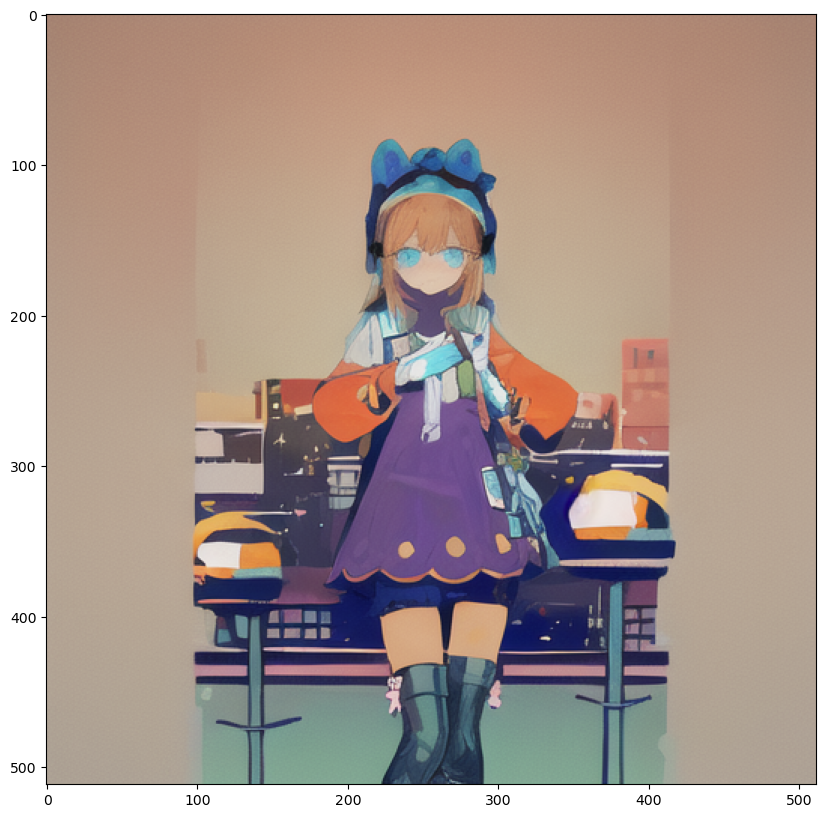

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image[0])